A Kaggle notebook for the Histopathologic Cancer Detection competition.

In this notebook I do a comparison of a known model (EfficientNetB2) against a small custom CNN model, both in Keras.

In this competition we must categorize images as either without evidence of cancer or with evidence of cancer.

The training set consists of 220025 96x96 pixel RGB images. All images are located in a single folder and are all in TIFF format.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import shutil
import os
from sklearn.model_selection import train_test_split

2024-05-08 18:55:40.135476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 18:55:40.135604: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 18:55:40.267278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Let us first take a look at what a few images look like. 

As we can see they look fairly normal with nice, clear patterns and they are indeed 96x96 pixels.

(96, 96)


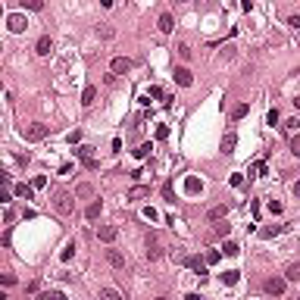

In [2]:
img = Image.open('/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')
print(img.size)
display(img.resize((300, 300)))

(96, 96)


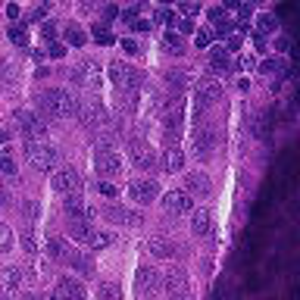

In [3]:
img = Image.open('/kaggle/input/histopathologic-cancer-detection/train/00039ed67c14391535d5ac933cc4854619849738.tif')
print(img.size)
display(img.resize((300, 300)))

There is not a lot of metadata to study or use in the model. Just the labels. 

If we look at the labels we see that they are binary 0 or 1 which would also be the most obvious choice for binary classification labels.

The training data is not well balanced with only 40.5% (89117 records) being a '1' label.

We could consider augmentations or use label weights to balance that out.

In [4]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df.head())
print()
print(df.describe())
print('\nTotal number of each label:')
print(df.groupby('label').count())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000

Total number of each label:
           id
label        
0      130908
1       89117


To make it easier for the data loading process let us sort the training images by label and save in the better compressed JPEG format. This will allow us to load the images easily by use of the image_dataset_from_directory functionality provided by the Keras framework. 

In [5]:
os.mkdir('0')
os.mkdir('1')

for index, row in df.iterrows():
    if index % 10000 == 0:
        print(str(index) + ' images moved (of ' + str(len(df.index)) + ')')
        
    img = Image.open('/kaggle/input/histopathologic-cancer-detection/train/' + row['id'] + '.tif')
    img.save(str(row['label']) + '/' + row['id'] + '.jpg') 

0 images moved (of 220025)
10000 images moved (of 220025)
20000 images moved (of 220025)
30000 images moved (of 220025)
40000 images moved (of 220025)
50000 images moved (of 220025)
60000 images moved (of 220025)
70000 images moved (of 220025)
80000 images moved (of 220025)
90000 images moved (of 220025)
100000 images moved (of 220025)
110000 images moved (of 220025)
120000 images moved (of 220025)
130000 images moved (of 220025)
140000 images moved (of 220025)
150000 images moved (of 220025)
160000 images moved (of 220025)
170000 images moved (of 220025)
180000 images moved (of 220025)
190000 images moved (of 220025)
200000 images moved (of 220025)
210000 images moved (of 220025)
220000 images moved (of 220025)


In order to load the images into the models for training we make use of image_dataset_from_directory which is able to split into train and validation datasets and 

In [6]:
validation_split = 0.05

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/',
    labels='inferred',
    label_mode='categorical',
    validation_split = validation_split,
    subset = "training",
    batch_size=16,
    image_size=img.size,
    seed = 0,
    shuffle = True)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/',
    labels='inferred',
    label_mode='categorical',
    validation_split = validation_split,
    subset = "validation",
    batch_size=16,
    image_size=img.size,
    seed = 0,
    shuffle = True)

Found 220025 files belonging to 2 classes.
Using 209024 files for training.
Found 220025 files belonging to 2 classes.
Using 11001 files for validation.


Now let's make a few models to compare

First model to test out if EfficientNetB2 which is in a family of very successful models. We'll use transfer learning and use the first 310 layers with the weights they have gotten from training on imagenet (freeze the first 310 layers) and only retrain the last. This will speed up training and help us avoid overfitting.

To further combat overfitting I've added 5 different image augmentation layers after the input layer that will change the training images slightly on each epoch. Finally a dropout layer is also added just before the final output layer.

In [7]:
model1_input = tf.keras.layers.Input(shape=(img.size[0], img.size[1], 3))
model1_augment1 = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")(model1_input)
model1_augment2 = tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="reflect")(model1_augment1)
model1_augment3 = tf.keras.layers.RandomRotation(0.5)(model1_augment2)
model1_augment4 = tf.keras.layers.RandomContrast(0.2)(model1_augment3)
model1_augment5 = tf.keras.layers.RandomBrightness(0.2)(model1_augment4)
model_base = tf.keras.applications.EfficientNetB2(input_tensor=model1_augment5, include_top=False, weights='imagenet')
model1_flatten = tf.keras.layers.Flatten()(model_base.output)
model1_dropout1 = tf.keras.layers.Dropout(0.15)(model1_flatten)
model1_dense1 = tf.keras.layers.Dense(20, activation='relu')(model1_dropout1)
model1_dropout2 = tf.keras.layers.Dropout(0.15)(model1_dense1)
model1_output = tf.keras.layers.Dense(2, activation='softmax')(model1_dropout2)

model1 = tf.keras.Model(model1_input, model1_output)

for i, layer in enumerate(model1.layers):
    if i < 310:
        layer.trainable = False
    
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model1.summary()

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 96, 96, 3) │          0 │ input_layer[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation  │ (None, 96, 96, 3) │          0 │ random_flip[0][0] │
│ (RandomTranslation) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 96, 96, 3) │          0 │ random_translati… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast     │ (None, 96, 96, 3) │          0 │ random_rotation[… │
│ (RandomContrast)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness   │ (None, 96, 96, 3) │          0 │ random_contrast[… │
│ (RandomBrightness)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 96, 96, 3) │          0 │ random_brightnes… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 96, 96, 3) │          7 │ rescaling[0][0]   │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 96, 96, 3) │          0 │ normalization[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 97, 97, 3) │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 48, 48,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 48, 48,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 48, 48,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 48, 48,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 48, 48,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 48, 48,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati

 Total params: 8,022,071 (30.60 MB)

 Trainable params: 3,747,754 (14.30 MB)

 Non-trainable params: 4,274,317 (16.31 MB)

In [8]:
model1.fit(train_ds, validation_data=validation_ds, epochs=15)

Epoch 1/15


2024-05-08 19:35:34.909257: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


13064/13064 ━━━━━━━━━━━━━━━━━━━━ 432s 31ms/step - accuracy: 0.8150 - loss: 0.4171 - val_accuracy: 0.8749 - val_loss: 0.3113
Epoch 2/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 391s 30ms/step - accuracy: 0.8578 - loss: 0.3371 - val_accuracy: 0.8846 - val_loss: 0.2947
Epoch 3/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 392s 30ms/step - accuracy: 0.8675 - loss: 0.3186 - val_accuracy: 0.8868 - val_loss: 0.2800
Epoch 4/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 392s 30ms/step - accuracy: 0.8728 - loss: 0.3065 - val_accuracy: 0.8852 - val_loss: 0.2965
Epoch 5/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 400s 31ms/step - accuracy: 0.8774 - loss: 0.2977 - val_accuracy: 0.8856 - val_loss: 0.3150
Epoch 6/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 393s 30ms/step - accuracy: 0.8801 - loss: 0.2917 - val_accuracy: 0.9012 - val_loss: 0.3185
Epoch 7/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 397s 30ms/step - accuracy: 0.8842 - loss: 0.2866 - val_accuracy: 0.8990 - val_loss: 0.2908
Epoch 8/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 395s 30ms/step - accur

The custom model has the same measures to avoid overfitting; 
5 different image augmentation layers after the input layer that will change the training images slightly on each epoch as well as a dropout layer just before the final output layer.

I've kept the filter counts on each convolutional layer fairly low and the kernel sizes small, mainly to speed up training.

In [9]:
model2_input = tf.keras.layers.Input(shape=(img.size[0], img.size[1], 3))
model2_augment1 = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")(model2_input)
model2_augment2 = tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode="reflect")(model2_augment1)
model2_augment3 = tf.keras.layers.RandomRotation(0.5)(model2_augment2)
model2_augment4 = tf.keras.layers.RandomContrast(0.2)(model2_augment3)
model2_augment5 = tf.keras.layers.RandomBrightness(0.2)(model2_augment4)
model2_cnn1 = tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), activation='relu')(model2_augment5)
model2_cnn2 = tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(2,2), activation='relu')(model2_cnn1)
model2_cnn3 = tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(1,1), activation='relu')(model2_cnn2)
model2_cnn4 = tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(2,2), activation='relu')(model2_cnn3)
model2_cnn5 = tf.keras.layers.Conv2D(50, kernel_size=(3,3), strides=(2,2), activation='relu')(model2_cnn4)
model2_flatten = tf.keras.layers.Flatten()(model2_cnn5)
model2_dropout = tf.keras.layers.Dropout(0.15)(model2_flatten)
model2_output = tf.keras.layers.Dense(2, activation='softmax')(model2_dropout)

model2 = tf.keras.Model(model2_input, model2_output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 96, 96, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 96, 96, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 96, 96, 3)      │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 94, 94, 50)     │         1,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 50)     │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 50)     │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 50)     │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 50)     │        22,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │        10,002 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,602 (396.88 KB)

 Trainable params: 101,602 (396.88 KB)

 Non-trainable params: 0 (0.00 B)

Fitting the custom model is significantly faster than the EfficientNet model.

In [10]:
model2.fit(train_ds, validation_data=validation_ds, epochs=15)

Epoch 1/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 168s 13ms/step - accuracy: 0.7344 - loss: 0.5767 - val_accuracy: 0.8084 - val_loss: 0.4225
Epoch 2/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 207s 13ms/step - accuracy: 0.8130 - loss: 0.4208 - val_accuracy: 0.8249 - val_loss: 0.3927
Epoch 3/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 165s 13ms/step - accuracy: 0.8333 - loss: 0.3818 - val_accuracy: 0.8387 - val_loss: 0.3689
Epoch 4/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 162s 12ms/step - accuracy: 0.8442 - loss: 0.3579 - val_accuracy: 0.8635 - val_loss: 0.3285
Epoch 5/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 162s 12ms/step - accuracy: 0.8544 - loss: 0.3386 - val_accuracy: 0.8654 - val_loss: 0.3117
Epoch 6/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 168s 13ms/step - accuracy: 0.8609 - loss: 0.3268 - val_accuracy: 0.8691 - val_loss: 0.3136
Epoch 7/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 166s 13ms/step - accuracy: 0.8660 - loss: 0.3183 - val_accuracy: 0.7952 - val_loss: 0.4323
Epoch 8/15
13064/13064 ━━━━━━━━━━━━━━━━━━━━ 201s 13ms/s

Looking at the results for transfer learning (model1) and for a new custom model (model2) we can see that, although model2 does a good job af separating the image classes, model1 is a bit better. We can see that the training loss and accuracy is jumping around a bit in the end of the training process which could be an indication that learning rate scheduling or a lower learning rate might yield slightly better and more consistent results. I see no evidence of overfitting. Obviously the large training dataset size helps here but also it seems the image augmentation and dropout works as expected. Without the image augmentation I did see some indications of overfitting, particularly with EfficientNetB2.

Transfer learning reached just over 91% accuracy on the validation dataset.

and

The custom model reached slightly above 90% accuracy on the validation dataset.

The final task is just to create the submission output file:

In [11]:
# First delete the two working directories with the training files so they are not in the output.
# If we don't it is going to be difficult to find the right file for scoring in the competition
try:
    shutil.rmtree('/kaggle/working/0')
    shutil.rmtree('/kaggle/working/1')
except FileNotFoundError:
    print('Could not delete directories')
    
id = []
label = []

directory='/kaggle/input/histopathologic-cancer-detection/test/'

for name in os.listdir(directory):
    img = Image.open('/kaggle/input/histopathologic-cancer-detection/test/' + name)
    res = model1(np.asarray(img).reshape((1, img.size[0], img.size[1], 3)), training=False)
    
    id.append(name.split('.')[0])
    if res[0, 0] > 0.5:
        label.append(0)
    else:
        label.append(1)
        
submit_df = pd.DataFrame()
submit_df['id'] = id
submit_df['label'] = label
submit_df.to_csv('submission.csv', index=False)

**Further improvements**

It could be interesting to experiment more with image augmentation that I have done here, in order to determine if it will improve model accuracy. Also other optimizers are worth exploring.

A challenge in testing out different models is the training time. The EfficientNet model takes 6 minutes for each epoch, even when using GPU (P100). This obviously makes it difficult to test a lot of configurations. Therefore it might also be an idea to test the accuracy of a much smaller model that would be faster to train.

In the end I feel both models are very successful, even if they are not on top of the Kaggle competition leaderboard.

# References
https://arxiv.org/pdf/1905.11946<br>
https://keras.io/api/layers/convolution_layers/<br>
https://github.com/TheRealLSM/HistopathologicCancerDetection<br>